# Phase 3 Project
- author: Jonathan Holt
- Flatiron Data Science
- 7/19/21 Cohort

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_rows', 1000) #change the amount of rows displayed
plt.style.use('seaborn')

In [3]:
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Fixing column names

In [4]:
df.columns = df.columns.str.replace(' ','_')
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

# Inital Data Exploration

In [5]:
#df.info()

In [6]:
#df.describe()

In [7]:
#df.isna().sum()

In [8]:
#df.churn.value_counts()

In [9]:
#df['total_intl_minutes'].value_counts()

# Cleaning and Preprocessing

In [10]:
#df.head()

In [11]:
test_df = df.copy()
test_df.head(2)

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


## Changing Yes and No to 0 and 1

In [12]:
test_df["churn"] = test_df["churn"].astype(int)

In [13]:
test_df.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [14]:
test_df = test_df.drop(columns=['state', 'phone_number', 'international_plan', 'voice_mail_plan'], axis=1)

In [15]:
test_df.head(1)

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,0


## Slicing out object type Features

In [16]:
cont_features = [col for col in test_df.columns if test_df[col].dtype in [np.float64, np.int64]]

In [17]:
cont_features

['account_length',
 'area_code',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'customer_service_calls',
 'churn']

In [18]:
feature_df = test_df.loc[:, cont_features]
#X_test_cat = X_test.loc[:, features_cat]
feature_df

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,0
3329,68,415,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,0
3330,28,510,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,0
3331,184,510,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,0


In [19]:
need_to_encode = test_df[['area_code', 'customer_service_calls']]

In [20]:
#IMPORTANT!
#Added 2/16 4PM. 
feature_df = feature_df.drop(need_to_encode, axis=1)
feature_df

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,churn
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,0
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,0
3329,68,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,0
3330,28,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,0
3331,184,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,0


In [21]:
ohe = OneHotEncoder()
ohe.fit(need_to_encode)

ohe_1 = ohe.transform(need_to_encode).toarray()

ohe_df = pd.DataFrame(ohe_1, columns=ohe.get_feature_names(need_to_encode.columns))
ohe_df.head()

,area_code_408,area_code_415,area_code_510,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Combining everything together

cleaned_df = pd.concat([pd.DataFrame(feature_df), ohe_df], axis=1)

In [23]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   account_length            3333 non-null   int64  
 1   number_vmail_messages     3333 non-null   int64  
 2   total_day_minutes         3333 non-null   float64
 3   total_day_calls           3333 non-null   int64  
 4   total_day_charge          3333 non-null   float64
 5   total_eve_minutes         3333 non-null   float64
 6   total_eve_calls           3333 non-null   int64  
 7   total_eve_charge          3333 non-null   float64
 8   total_night_minutes       3333 non-null   float64
 9   total_night_calls         3333 non-null   int64  
 10  total_night_charge        3333 non-null   float64
 11  total_intl_minutes        3333 non-null   float64
 12  total_intl_calls          3333 non-null   int64  
 13  total_intl_charge         3333 non-null   float64
 14  churn   

In [24]:
X = cleaned_df.drop(['churn'], axis=1)
#X = test_df[['area_code', 'international_plan', 'voice_mail_plan', 'customer_service_calls' ]]
y = cleaned_df['churn']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=23)

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2499 entries, 978 to 595
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   account_length            2499 non-null   int64  
 1   number_vmail_messages     2499 non-null   int64  
 2   total_day_minutes         2499 non-null   float64
 3   total_day_calls           2499 non-null   int64  
 4   total_day_charge          2499 non-null   float64
 5   total_eve_minutes         2499 non-null   float64
 6   total_eve_calls           2499 non-null   int64  
 7   total_eve_charge          2499 non-null   float64
 8   total_night_minutes       2499 non-null   float64
 9   total_night_calls         2499 non-null   int64  
 10  total_night_charge        2499 non-null   float64
 11  total_intl_minutes        2499 non-null   float64
 12  total_intl_calls          2499 non-null   int64  
 13  total_intl_charge         2499 non-null   float64
 14  area_co

# Decision Tree 1

In [27]:
dtree_1 = DecisionTreeClassifier()

dt1_cv_score = cross_val_score(dtree_1, X_train, y_train, cv=3)
mean_dt1_cv_score = np.mean(dt1_cv_score)

print(f"DTree 1 Mean Cross Validation Score: {mean_dt1_cv_score :.2%}")

DTree 1 Mean Cross Validation Score: 84.31%


## GridSearchCV

In [28]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [29]:
# Instantiate GridSearchCV
dt1_grid_search = GridSearchCV(dtree_1, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt1_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [30]:
# Mean training score
dt1_gs_training_score = np.mean(dt1_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt1_gs_testing_score = dt1_grid_search.score(X_test, y_test)

print(f"DTree 1 Mean Training Score: {dt1_gs_training_score :.2%}")
print(f"DTree 1 Mean Test Score: {dt1_gs_testing_score :.2%}")
print("DTree 1 Best Parameter Combination Found During Grid Search:")
dt1_grid_search.best_params_

DTree 1 Mean Training Score: 91.73%
DTree 1 Mean Test Score: 91.01%
DTree 1 Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [31]:
dtree_1.fit(X_train, y_train)
y_pred = dtree_1.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
dt1_roc_auc = auc(false_positive_rate, true_positive_rate)
dt1_roc_auc
print(f"DTree 1 AUC Score: {dt1_roc_auc :.2%}")

DTree 1 AUC Score: 74.73%


# Random Forests 1

In [32]:
rf1_clf = RandomForestClassifier()
mean_rf1_cv_score = np.mean(cross_val_score(rf1_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf1_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 90.56%


In [33]:
rf1_clf.fit(X_train, y_train)
y_pred = rf1_clf.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
rf1_roc_auc = auc(false_positive_rate, true_positive_rate)
rf1_roc_auc
print(f"Random Forests 1 AUC Score: {rf1_roc_auc :.2%}")

Random Forests 1 AUC Score: 75.77%


## GridSearch_CV

In [34]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [35]:
rf1_grid_search = GridSearchCV(rf1_clf, rf_param_grid, cv=3)
rf1_grid_search.fit(X_train, y_train)

print(f"Random Forest 1 Training Accuracy: {rf1_grid_search.best_score_ :.2%}")
print("")
print(f"Random Forest 1 Optimal Parameters: {rf1_grid_search.best_params_}")

Random Forest 1 Training Accuracy: 90.08%

Random Forest 1 Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


In [36]:
rf2_clf = RandomForestClassifier(criterion= 'entropy',
                                max_depth= 10,
                                min_samples_leaf= 3,
                                min_samples_split= 5,
                                n_estimators= 100)

mean_rf2_cv_score = np.mean(cross_val_score(rf2_clf, X_train, y_train, cv=3))

print(f"Random Forests 2 Mean Cross Validation Score: {mean_rf2_cv_score :.2%}")

Random Forests 2 Mean Cross Validation Score: 90.28%


In [37]:
dt1_score = dt1_grid_search.score(X_test, y_test)
rf1_score = rf1_grid_search.score(X_test, y_test)

print('Decision tree 1 grid search Score: ', dt1_score)
print('Random forest 1 grid search Score: ', rf1_score)

Decision tree 1 grid search Score:  0.9100719424460432
Random forest 1 grid search Score:  0.907673860911271


# Decision Tree 2 using params from GridSearch CV

In [38]:
dtree_2 = DecisionTreeClassifier(criterion='gini', 
                           max_depth=5,
                           min_samples_split=2,
                           min_samples_leaf=6,
                            random_state=23)
dt2_cv_score = cross_val_score(dtree_2, X_train, y_train, cv=3)
mean_dt2_cv_score = np.mean(dt2_cv_score)

print(f"DTree 2 Mean Cross Validation Score: {mean_dt2_cv_score :.2%}")

DTree 2 Mean Cross Validation Score: 89.68%


In [39]:
#dtree_2.fit(X_train, y_train)
#y_pred = dtree_2.predict(X_test)
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#roc_auc = auc(false_positive_rate, true_positive_rate)
#roc_auc

In [40]:
#dtree_2.feature_importances_

In [41]:
dt2_cv_score = cross_val_score(dtree_2, X_train, y_train, cv=3)
mean_dt2_cv_score = np.mean(dt2_cv_score)

print(f"Decision Tree 2 Mean Cross Validation Score: {mean_dt2_cv_score :.2%}")

Decision Tree 2 Mean Cross Validation Score: 89.68%


# Comparisons

In [42]:
print(f"DTree 1 Mean Cross Validation Score: {mean_dt1_cv_score :.2%}")
print(f"DTree 1 Mean Training Score: {dt1_gs_training_score :.2%}")
print(f"DTree 1 Mean Test Score: {dt1_gs_testing_score :.2%}")
print('Decision tree 1 grid search Score: ', dt1_score)
print(f"DTree 1 AUC Score: {dt1_roc_auc :.2%}")
print('--------------------------------')
print(f"RandomForest 1 Mean Cross Validation Score: {mean_rf1_cv_score :.2%}")
print(f"Random Forest 1 Training Accuracy: {rf1_grid_search.best_score_ :.2%}")
print('Random forest 1 grid search Score: ', rf1_score)
print(f"Random Forests 1 AUC Score: {rf1_roc_auc :.2%}")
print('--------------------------------')
print(f"DTree 2 Mean Cross Validation Score: {mean_dt2_cv_score :.2%}")
print('--------------------------------')
print(f"Random Forests 2 Mean Cross Validation Score: {mean_rf2_cv_score :.2%}")


DTree 1 Mean Cross Validation Score: 84.31%
DTree 1 Mean Training Score: 91.73%
DTree 1 Mean Test Score: 91.01%
Decision tree 1 grid search Score:  0.9100719424460432
DTree 1 AUC Score: 74.73%
--------------------------------
RandomForest 1 Mean Cross Validation Score: 90.56%
Random Forest 1 Training Accuracy: 90.08%
Random forest 1 grid search Score:  0.907673860911271
Random Forests 1 AUC Score: 75.77%
--------------------------------
DTree 2 Mean Cross Validation Score: 89.68%
--------------------------------
Random Forests 2 Mean Cross Validation Score: 90.28%


### Analysis:
    - Explain what cross validation score means
    - explain what training score means
    - explain what test score means
    - explain what grid search score means
    - explain what ROC AUC score means

## Optimal Parameters

In [43]:
print("DTree 1 Best Parameter Combination Found During Grid Search:")
dt1_grid_search.best_params_

DTree 1 Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [44]:
print(f"Random Forest 1 Optimal Parameters: {rf1_grid_search.best_params_}")

Random Forest 1 Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


## Feature Importance

In [85]:
feature_names = list(X)
feature_names

['account_length',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'area_code_408',
 'area_code_415',
 'area_code_510',
 'customer_service_calls_0',
 'customer_service_calls_1',
 'customer_service_calls_2',
 'customer_service_calls_3',
 'customer_service_calls_4',
 'customer_service_calls_5',
 'customer_service_calls_6',
 'customer_service_calls_7',
 'customer_service_calls_8',
 'customer_service_calls_9']

In [86]:
rf1_importance = rf1_clf.feature_importances_
rf1_importance

array([0.04289213, 0.04149043, 0.13898743, 0.04374914, 0.14337189,
       0.06772985, 0.04093122, 0.07283627, 0.04892916, 0.04547302,
       0.04648009, 0.04374009, 0.03307259, 0.04382365, 0.0068621 ,
       0.00758188, 0.0075801 , 0.006359  , 0.00664475, 0.00510094,
       0.00394442, 0.04152686, 0.03064477, 0.01648845, 0.00923101,
       0.00239349, 0.00213527])

In [87]:
feature_importance_df = pd.DataFrame(rf1_importance, feature_names)
feature_importance_df

,0
account_length,0.042892
number_vmail_messages,0.041490
total_day_minutes,0.138987
total_day_calls,0.043749
total_day_charge,0.143372
total_eve_minutes,0.067730
total_eve_calls,0.040931
total_eve_charge,0.072836
total_night_minutes,0.048929
total_night_calls,0.045473


In [88]:
feature_importance_df= feature_importance_df.reset_index()

In [89]:
feature_importance_df.rename(columns={'index': 'Feature', 0: 'Importance'}, inplace=True)
feature_importance_df

,Feature,Importance
0,account_length,0.042892
1,number_vmail_messages,0.041490
2,total_day_minutes,0.138987
3,total_day_calls,0.043749
4,total_day_charge,0.143372
5,total_eve_minutes,0.067730
6,total_eve_calls,0.040931
7,total_eve_charge,0.072836
8,total_night_minutes,0.048929
9,total_night_calls,0.045473


In [97]:
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

,Feature,Importance
4,total_day_charge,0.143372
2,total_day_minutes,0.138987
7,total_eve_charge,0.072836
5,total_eve_minutes,0.067730
8,total_night_minutes,0.048929
10,total_night_charge,0.046480
9,total_night_calls,0.045473
13,total_intl_charge,0.043824
3,total_day_calls,0.043749
11,total_intl_minutes,0.043740


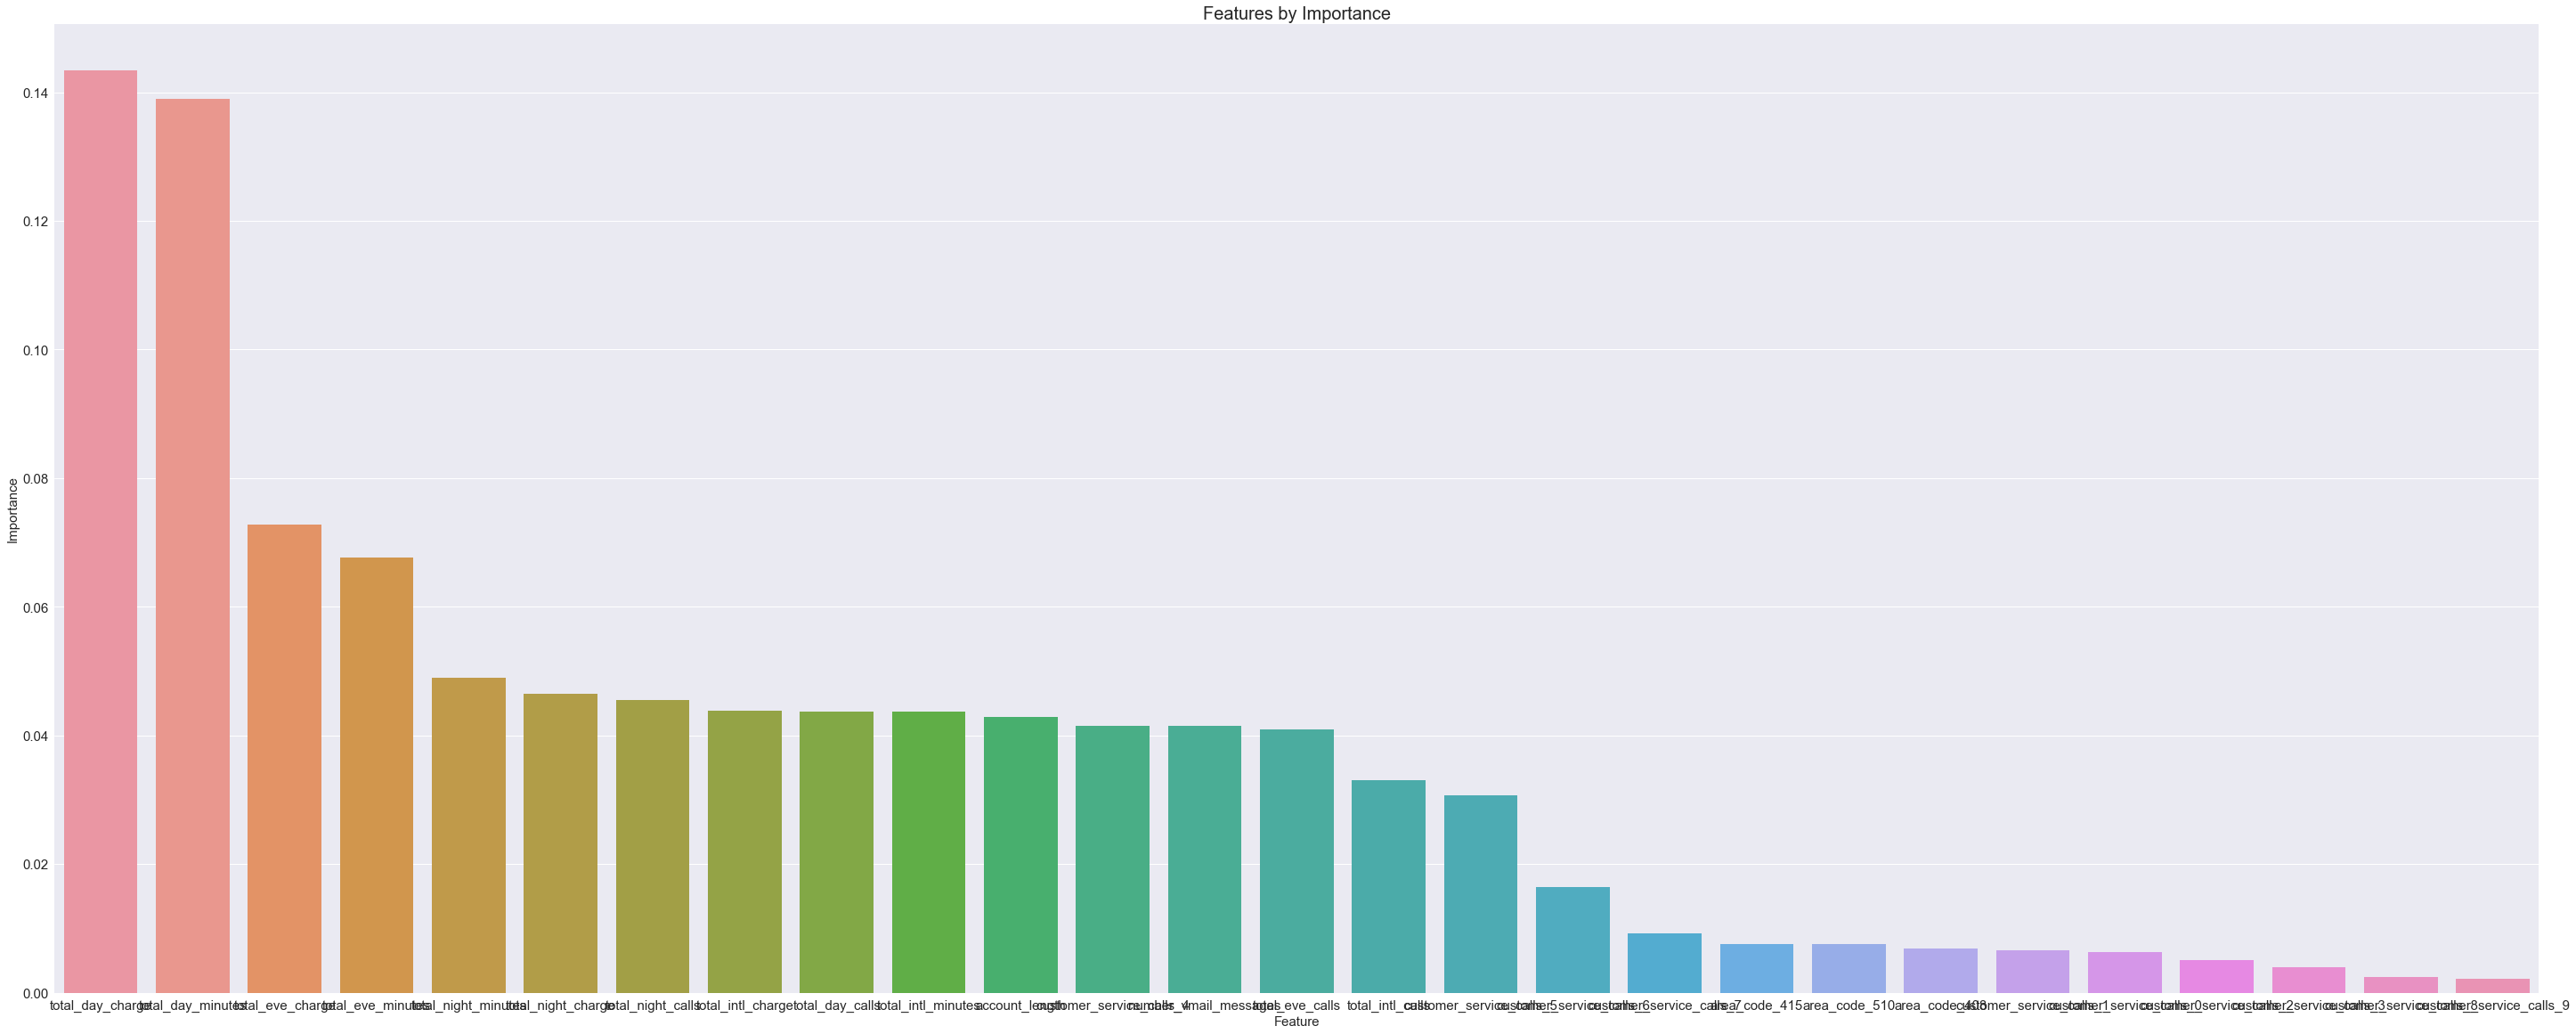

In [101]:
# plot feature importance
fig, ax = plt.subplots(figsize=(50,20))
p = sns.barplot(data=feature_importance_df, x='Feature', y='Importance' );

p.set_xlabel("Feature", fontsize = 15)

p.set_ylabel("Importance", fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#p.yaxis.set_major_formatter(display_millions)
p.set_title("Features by Importance", fontsize = 20)
plt.figsize=(30,20) 
#plt.savefig('images/project_1_bar_3')

plt.show();

In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   account_length            3333 non-null   int64  
 1   number_vmail_messages     3333 non-null   int64  
 2   total_day_minutes         3333 non-null   float64
 3   total_day_calls           3333 non-null   int64  
 4   total_day_charge          3333 non-null   float64
 5   total_eve_minutes         3333 non-null   float64
 6   total_eve_calls           3333 non-null   int64  
 7   total_eve_charge          3333 non-null   float64
 8   total_night_minutes       3333 non-null   float64
 9   total_night_calls         3333 non-null   int64  
 10  total_night_charge        3333 non-null   float64
 11  total_intl_minutes        3333 non-null   float64
 12  total_intl_calls          3333 non-null   int64  
 13  total_intl_charge         3333 non-null   float64
 14  area_cod

## Analysis
- Figure out how to rank feature importance as this is the ultimate outcome for my business problem.
- VISUALIZE!!!!

# Plot Decision Tree

## Analysis:
    - A plot of a Decision Tree might make fore a nice visual.

# Archive

## Attempting Tree With CLEANED DF intead of test_df

In [47]:
X = cleaned_df.drop(['churn'], axis=1)
#X = test_df[['area_code', 'international_plan', 'voice_mail_plan', 'customer_service_calls' ]]
y = cleaned_df['churn']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=23)

In [49]:
dt3 = DecisionTreeClassifier()

dt3_cv_score = cross_val_score(dt3, X_train, y_train, cv=3)
mean_dt3_cv_score = np.mean(dt3_cv_score)

print(f"Cleantree 1 Mean Cross Validation Score: {mean_dt3_cv_score :.2%}")

Cleantree 1 Mean Cross Validation Score: 84.23%


### GridSearchCV

In [50]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [51]:
# Instantiate GridSearchCV
dt3_grid_search = GridSearchCV(dt3, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt3_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [52]:
# Mean training score
dt3_gs_training_score = np.mean(dt3_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt3_gs_testing_score = dt3_grid_search.score(X_test, y_test)

print(f"CleanTree 1 Mean Training Score: {dt3_gs_training_score :.2%}")
print(f"CleanTree 1 Mean Test Score: {dt3_gs_testing_score :.2%}")
print("CleanTree 1 Best Parameter Combination Found During Grid Search:")
dt3_grid_search.best_params_

CleanTree 1 Mean Training Score: 91.73%
CleanTree 1 Mean Test Score: 91.37%
CleanTree 1 Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 6,
 'min_samples_split': 2}

## CleanTree Model 2

In [53]:
cleantree_2 = DecisionTreeClassifier(criterion='gini', 
                           max_depth=5,
                           min_samples_split=2,
                            min_samples_leaf=6,
                            random_state=23)
cleantree_2.fit(X_train, y_train)
y_pred = cleantree_2.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
cleantree_2_roc_score = roc_auc


In [54]:
cleantree_2_roc_score

0.7601224105461394

In [55]:
print(f"DTree 1 Mean Cross Validation Score: {mean_dtree_1_cv_score :.2%}")
print ("Decision Tree 1")
print(f"Mean Training Score: {dt1_gs_training_score :.2%}")
print(f"Mean Test Score: {dt1_gs_testing_score :.2%}")
print('--------------------------------')
print(f"Decision Tree 2 Mean Cross Validation Score: {mean_dt2_cv_score :.2%}")
print('--------------------------------')
print(f"Cleantree 1 Mean Cross Validation Score: {mean_dt3_cv_score :.2%}")
print(f"CleanTree 1 Mean Training Score: {dt3_gs_training_score :.2%}")
print(f"CleanTree 1 Mean Test Score: {dt3_gs_testing_score :.2%}")
print('--------------------------------')
print("Cleantree 2 ROC AUC Score:", cleantree_2_roc_score)
print('--------------------------------')
print(f"Random Forests 1 Training Accuracy: {rf1_grid_search.best_score_ :.2%}")

NameError: name 'mean_dtree_1_cv_score' is not defined

In [ ]:
print('Decision tree 1 grid search: ', dt1_score)
print('Random forest 1 grid search: ', rf1_score)

## Decision Tree (Attempt #2) 2/16

In [ ]:
ohe = OneHotEncoder()
ohe.fit(X_train)

X_train_ohe = ohe.transform(X_train).toarray()

ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))
ohe_df.head()

In [ ]:
ohe.fit(X_train)

In [ ]:
X_train_ohe = ohe.transform(X_train).toarray()

In [ ]:
ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))
ohe_df.head()

In [ ]:
dtree_baseline=DecisionTreeClassifier(criterion='entropy', random_state=23)
dtree_baseline.fit(X_train_ohe, y_train)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(5,5), dpi=300)

tree.plot_tree(dtree_baseline,
              feature_names = ohe_df.columns,
               class_names = np.unique(y).astype('str'),
               filled=True)
plt.show()

In [ ]:
X_test_ohe = ohe.transform(X_test)
y_pred = dtree_baseline.predict(X_test_ohe)

print('Accuracy:', accuracy_score(y_test, y_pred))

In [ ]:
# Check the AUC of predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

In [ ]:
#dtree_baseline_log_loss = -cross_val_score(dtree_baseline, X_train, y_train, scoring="neg_log_loss").mean()
#dtree_baseline_log_loss